# First Order PDE in Two Dimensions

In [14]:
from pyomo.environ import *
from pyomo.dae import *

### Plotting Function

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

def model_plot(m):
    x = sorted(m.x)
    t = sorted(m.t)

    xgrid = np.zeros((len(t), len(x)))
    tgrid = np.zeros((len(t), len(x)))
    ugrid = np.zeros((len(t), len(x)))

    for i in range(0, len(t)):
        for j in range(0, len(x)):
            xgrid[i,j] = x[j]
            tgrid[i,j] = t[i]
            ugrid[i,j] = m.u[x[j], t[i]].value

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('Distance x')
    ax.set_ylabel('Time t')
    ax.set_zlabel('u')
    p = ax.plot_wireframe(xgrid, tgrid, ugrid)

## Linear Case

### Example: Constant Velocity Wave

The basic transport equation consists of a first order PDE with a coefficient $c$ corresponding to the transport velocity.

\begin{align*}
\frac{\partial u}{\partial t} + c \frac{\partial x}{\partial x} & = 0 \\
\end{align*}

with

\begin{align*}
u(0,t) & = 1 & t > 0 \\
u(x,0) & = 0 & x > 0
\end{align*}

The key to understanding this equation is to consider any differentiable function $u(x,t)$ where $x$ and $t$ are functions of an underlying variable $z$. Then

\begin{align*}
du & = \frac{\partial u}{\partial t}\frac{dt}{dz} + \frac{\partial u}{\partial x}\frac{dx}{dz}
\end{align*}

We recover the original equation with $du = 0$ provided

\begin{align*}
\frac{dt}{dz} & = 1 \\
\frac{dx}{dz} & = c \\
\end{align*}

Thus $u$ is a constant on linear trajectories parameterized as $(x,t) = (cs, s) = (ct, t)$.

Ipopt 3.12.10: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    44163
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    11163
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    11162
Total number of in

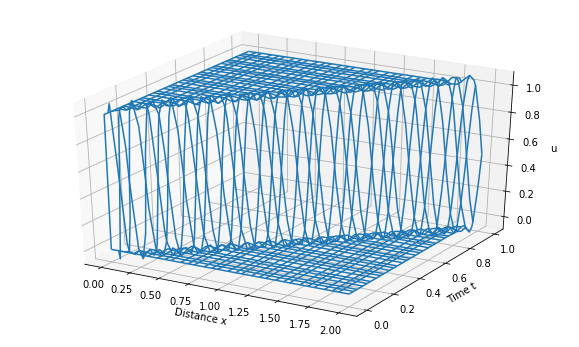

In [16]:
m = ConcreteModel()

m.x = ContinuousSet(bounds=(0, 2))
m.t = ContinuousSet(bounds=(0, 1))
m.u = Var(m.x, m.t)
m.dudx = DerivativeVar(m.u, wrt=m.x)
m.dudt = DerivativeVar(m.u, wrt=m.t)

c = 2

m.pde = Constraint(m.x, m.t, rule=lambda m, x, t: m.dudt[x,t] + c*m.dudx[x,t] == 0)
m.ic = Constraint(m.x, rule=lambda m, x: m.u[x,0] == 0 if x <= 1 else m.u[x,0] == 0)
m.bc = Constraint(m.t, rule=lambda m, t: m.u[0,t] == 1 if t > 0 else Constraint.Skip)

TransformationFactory('dae.collocation').apply_to(m, nfe=20, ncp=3)
SolverFactory('ipopt').solve(m, tee=True)

model_plot(m)

## Quasi-Linear Case

### Example: Formation of a Shock Wave

\begin{align*}
\frac{\partial u}{\partial t} + (1 + u)\frac{\partial u}{\partial x} & = 0 \
\end{align*}

with

\begin{align*}
u(0,t) & = 1 & t > 0 \\
u(x,0) & = 1 - x & 0 \leq x \leq 1 \\
u(x,0) & = 0 & x > 1
\end{align*}

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 30602
  Number of variables: 30603
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.10\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 6.120804786682129
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


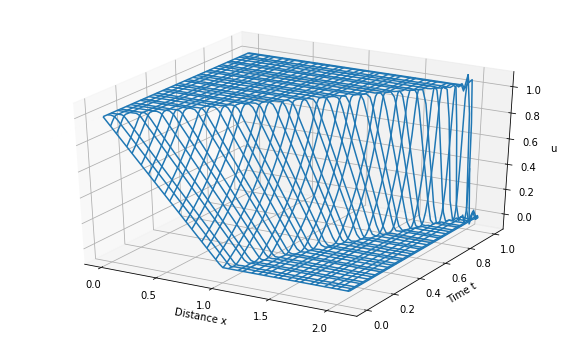

In [17]:
m = ConcreteModel()

m.x = ContinuousSet(bounds=(0, 2.1))
m.t = ContinuousSet(bounds=(0, 1))
m.u = Var(m.x, m.t)
m.dudx = DerivativeVar(m.u, wrt=m.x)
m.dudt = DerivativeVar(m.u, wrt=m.t)

m.pde = Constraint(m.x, m.t, rule=lambda m, x, t: m.dudt[x,t] + (1+m.u[x,t])*m.dudx[x,t] == 0)
m.ic = Constraint(m.x, rule=lambda m, x: m.u[x,0] == 1 - x if x <= 1 else m.u[x,0] == 0)
m.bc = Constraint(m.t, rule=lambda m, t: m.u[0,t] == 1 if t > 0 else Constraint.Skip)

TransformationFactory('dae.collocation').apply_to(m, nfe=20, ncp=5)
solver = SolverFactory('ipopt')
solver.options['linear_solver'] = 'MA57'
solver.solve(m).write()

model_plot(m)

### Example: Expansive Wave

\begin{align*}
\frac{\partial u}{\partial t} + (1 + u)\frac{\partial u}{\partial x} & = 0 \
\end{align*}

with

\begin{align*}
u(0,t) & = 0 & t > 0 \\
u(x,0) & = x & 0 \leq x \leq 1 \\
u(x,0) & = 1 & x > 1
\end{align*}

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 30602
  Number of variables: 30603
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.10\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 2.163892984390259
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


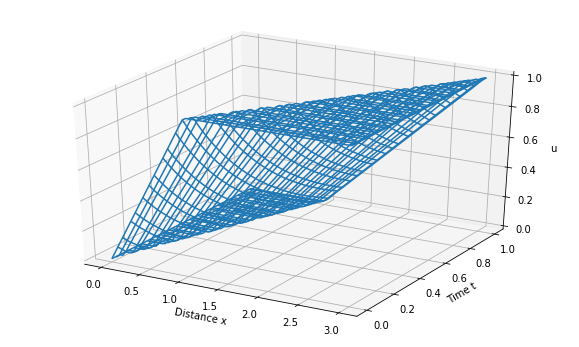

In [19]:
m = ConcreteModel()

m.x = ContinuousSet(bounds=(0, 3))
m.t = ContinuousSet(bounds=(0, 1))
m.u = Var(m.x, m.t)
m.dudx = DerivativeVar(m.u, wrt=m.x)
m.dudt = DerivativeVar(m.u, wrt=m.t)

m.pde = Constraint(m.x, m.t, rule=lambda m, x, t: m.dudt[x,t] + (1+m.u[x,t])*m.dudx[x,t] == 0)
m.ic = Constraint(m.x, rule=lambda m, x: m.u[x,0] == x if x <= 1 else m.u[x,0] == 1)
m.bc = Constraint(m.t, rule=lambda m, t: m.u[0,t] == 0 if t > 0 else Constraint.Skip)

TransformationFactory('dae.collocation').apply_to(m, nfe=20, ncp=5)
solver = SolverFactory('ipopt')
solver.options['linear_solver'] = 'MA57'
solver.solve(m).write()

model_plot(m)

## Tubular Reactor

In [20]:
m = ConcreteModel()

m.z = ContinuousSet(bounds=(0,1))
m.t = ContinuousSet(bounds=(0,1))

m.x1 = Var(m.z, m.t)
m.x2 = Var(m.z, m.t)

m.dx1dt = DerivativeVar(m.x1, wrt=m.t)
m.dx1dz = DerivativeVar(m.x1, wrt=m.z)
m.dx2dt = DerivativeVar(m.x2, wrt=m.t)
m.dx2dz = DerivativeVar(m.x2, wrt=m.z)

Bt = 2.5
Bc = 0.1
beta = 2
Ti = 0.5
Tj = -0.5
gamma = 10

m.ode1 = Constraint(m.z, m.t, rule=lambda m, z, t: 
    m.dx1dt[z,t] == -m.dx1dz[z,t] + Bt*Bc*exp(gamma*m.x1[z,t]/(1 + m.x1[z,t]))*(1+m.x2[z,t])**2 + beta*(Tj-m.x1[z,t])
)

m.ode2 = Constraint(m.z, m.t, rule=lambda m, z, t:
    m.dx2dt[z,t] == -m.dx2dz[z,t] + Bc*exp(gamma*m.x1[z,t]/(1 + m.x1[z,t]))*(1+m.x2[z,t])**2
)

m.bc1 = Constraint(m.t, rule=lambda m, t: m.x1[0,t] == Ti)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.x2[0,t] == 0.5)

m.ic1 = Constraint(m.z, rule=lambda m, z: m.x1[z,0] == Ti)
m.ic2 = Constraint(m.z, rule=lambda m, z: m.x2[z,0] == 0.5)

TransformationFactory('dae.collocation').apply_to(m, ncp=10)
#TransformationFactory('dae.finite_difference').apply_to(m, nfe=10, wrt=m.t, scheme='BACKWARD')
SolverFactory('ipopt').solve(m).write()

    model=unknown;
        message from solver=Ipopt 3.12.10\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 61206
  Number of variables: 61206
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.10\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 144.0075569152832
# ---------------------